In [2]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot
import seaborn as sns
from tqdm import tqdm

In [3]:
train_set = pd.read_csv("train.tsv", sep='\t')
test_set = pd.read_csv('test.tsv', sep='\t')

In [4]:
train_set.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [5]:
test_set.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [6]:
train_set = train_set.iloc[:,[2,3]]

In [7]:
train_set.head(10)

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2
5,of escapades demonstrating the adage that what...,2
6,of,2
7,escapades demonstrating the adage that what is...,2
8,escapades,2
9,demonstrating the adage that what is good for ...,2


In [8]:
train_set.shape

(156060, 2)

In [9]:
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
import re

In [10]:
def cleaning_review(df):
    reviews = []
    
    for sent in tqdm(df["Phrase"]):
        
        sent = sent.lower()
        clean_sent = sent.translate(str.maketrans('','',string.punctuation))
        words = word_tokenize(sent)
        words  = [k for k in words if k not in stopwords.words('english')]
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        
        reviews.append(lemma_words)
        
    return(reviews)        

In [11]:
train_sent = cleaning_review(train_set)

100%|█████████████████████████████████████████████████████████████████████████| 156060/156060 [12:29<00:00, 208.30it/s]


In [12]:
test_sent = cleaning_review(test_set)

100%|███████████████████████████████████████████████████████████████████████████| 66292/66292 [04:58<00:00, 222.01it/s]


In [13]:
print(len(train_set))
print(len(test_set))

156060
66292


In [14]:
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical

In [15]:
target=train_set.Sentiment.values
y=to_categorical(target)
num_classes=y.shape[1]

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
x_train,x_val,y_train,y_val = train_test_split(train_sent,y, test_size=0.2,random_state=10,stratify=y)

In [18]:
unique_words = set()
len_max = 0

for sent in tqdm(x_train):
    unique_words.update(sent)
    
    if len_max<len(sent):
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|██████████████████████████████████████████████████████████████████████| 124848/124848 [00:00<00:00, 397402.46it/s]

15057
38


In [19]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [20]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(x_train))

x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(test_sent)


x_train = sequence.pad_sequences(x_train,maxlen=len_max)
x_val = sequence.pad_sequences(x_val,maxlen=len_max)
x_test = sequence.pad_sequences(x_test,maxlen=len_max)


In [21]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=2,monitor='val_acc')
callback = [early_stopping]

In [23]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM

In [26]:
rnn = Sequential()

rnn.add(Embedding(len(list(unique_words)),300,input_length=len_max))
rnn.add(LSTM(128,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))
rnn.add(LSTM(64,dropout=0.5,recurrent_dropout=0.5,return_sequences=False))
rnn.add(Dense(100,activation='relu'))
rnn.add(Dropout(0.5))
rnn.add(Dense(num_classes,activation="softmax"))
rnn.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

rnn.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 38, 300)           4517100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 38, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 4,793,161
Trainable params: 4,793,161
Non-trainable params: 0
____________________________________________

In [27]:
history = rnn.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=8,batch_size=256 ,callbacks=callback)

C:\Users\danis\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 124848 samples, validate on 31212 samples
Epoch 1/8
124848/124848 [==============================] - 328s 3ms/step - loss: 1.1596 - accuracy: 0.5414 - val_loss: 0.9755 - val_accuracy: 0.6093
Epoch 2/8


C:\Users\danis\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


124848/124848 [==============================] - 320s 3ms/step - loss: 0.9048 - accuracy: 0.6413 - val_loss: 0.8537 - val_accuracy: 0.6517
Epoch 3/8
124848/124848 [==============================] - 325s 3ms/step - loss: 0.8178 - accuracy: 0.6729 - val_loss: 0.8316 - val_accuracy: 0.6633
Epoch 4/8
124848/124848 [==============================] - 336s 3ms/step - loss: 0.7745 - accuracy: 0.6862 - val_loss: 0.8294 - val_accuracy: 0.6632
Epoch 5/8
124848/124848 [==============================] - 340s 3ms/step - loss: 0.7431 - accuracy: 0.6971 - val_loss: 0.8420 - val_accuracy: 0.6652
Epoch 6/8
124848/124848 [==============================] - 347s 3ms/step - loss: 0.7207 - accuracy: 0.7036 - val_loss: 0.8407 - val_accuracy: 0.6672
Epoch 7/8
124848/124848 [==============================] - 306s 2ms/step - loss: 0.6953 - accuracy: 0.7115 - val_loss: 0.8479 - val_accuracy: 0.6633
Epoch 8/8
124848/124848 [==============================] - 157s 1ms/step - loss: 0.6776 - accuracy: 0.7166 - val_los

In [29]:
import matplotlib.pyplot as plt

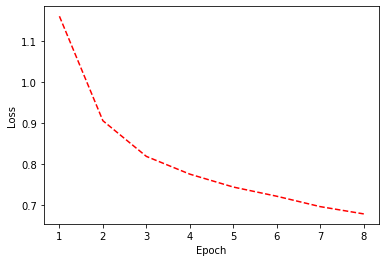

In [30]:
epoch_count = range(1, len(history.history['loss']) + 1)
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [36]:
y_pred = rnn.predict_classes(x_test)

In [37]:
y_pred

array([3, 3, 2, ..., 1, 1, 2], dtype=int64)

## From here the user input prediction is done, the procedure is as follows:

In [40]:
pred_set = pd.read_csv("prediction.csv")

In [41]:
pred_set.head()

,Phrase
0,This is a goog movie
1,This is a bad movie
2,This movie is one of a kind
3,This is genuine masterpiece
4,this movie is such a waste of time


In [43]:
pred_sent = cleaning_review(pred_set)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 673.20it/s]


In [50]:
pred = tokenizer.texts_to_sequences(pred_sent)
pred = sequence.pad_sequences(pred,maxlen=38)

In [51]:
y_pred2 = rnn.predict_classes(pred)

In [52]:
y_pred2

array([2, 0, 2, 4, 0], dtype=int64)